# Data Analytics final project

*Dominik Woźniak & Patryk Tomaszewski, 2022*

## Project goals

- Select a phenomena to model and find data for it.
- Propose two models to represent the phenomena.
- Perform prior analysis and selection.
- Fit the models and analyze posterior predictive distributions - are they capturing the data. Repeat steps 3-5 if necessary.
- Perform comparison of models with WAIC and LOO information criteria.
- Report your findings

1. Problem formulation [0-4 pts]:
  - is the problem clearly stated [1 pt]
  - what is the point of creating model, are potential use cases defined [1 pt]
  - where do data comes from, what does it containt [1 pt]
  - is preprocessing step clearly described [1 pt]
2. Model [0-4 pts]
  - are two different models specified [1 pt] 
  - are difference between two models explained [1 pt]
  - is the difference in the models justified (e.g. does adding aditional parameter makes sense? ) [1 pt]
  - are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt]
3. Priors [0-4 pts] 
  - Is it explained why particular priors for parameters were selected [1 pt]
  - Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
  - Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
  - How prior parameters were selected [1 pt] 
4. Posterior analysis (model 1) [0-4 pts] 
  - were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
  - are the samples from posterior predictive distribution analyzed [1 pt]
  - are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
  - have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]  
5. Posterior analysis (model 2) [0-4 pts] 
  - were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
  - are the samples from posterior predictive distribution analyzed [1 pt]
  - are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
  - have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]  
6. Model comaprison [0-4 pts]
  - Have models been compared using information criteria [1 pt]
  - Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
  - Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
  - Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]

## Dataset

The data was extracted from the 1974 Motor Trend US magazine, and comprises fuel consumption and 10 aspects of automobile design and performance for 32 automobiles (1973--74 models).

https://www.kaggle.com/datasets/ruiromanini/mtcars

- `mpg` - Miles pre gallon
- `cyl` - Number of cylinders
- `disp` - Displacement (cu. in.)
- `hp` - Gross horsepower
- `drat` - Rear axle ratio
- `wt` - Weight (1000 lbs)
- `qsec` - 1/4 mile time
- `vs` - Engine (0 = V-shaped, 1 = straight)
- `am` - Transmission (0 = automatic, 1 = manual)
- `gear` - No of forward gears
- `carb` - No of carburetors

In [16]:
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cmdstanpy import CmdStanModel

In [17]:
data = pd.read_csv('data.csv')

In [18]:
data.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


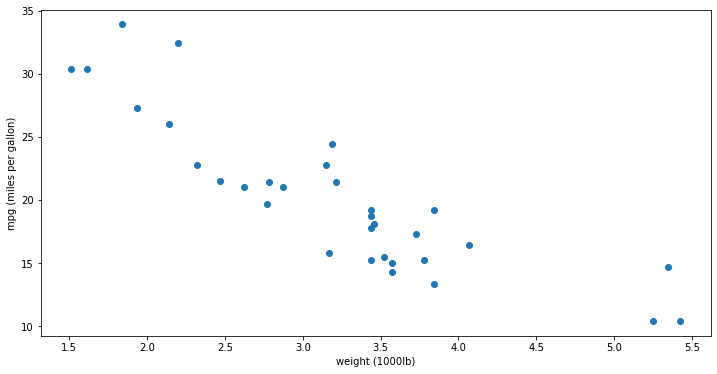

In [19]:
plt.figure(figsize=(12,6))
plt.scatter(data['wt'], data['mpg'])
plt.xlabel('weight (1000lb)')
plt.ylabel('mpg (miles per gallon)')
plt.show()

## Project overview

For our research question, we will be investigating how different characteristics of a car affect it’s fuel consumption - Miles per galon (MPG)

Observing the above graph, we can notice negative relationship between these variables. The goal will be to find that relationship.

### Improving data

Before we start working on the analysis, we can make some improvements to the model.

The first change that can be made to the model is center variables (`weight`, `cylinders`, `hp`) so that we can get a more meaningful interpretation of the intercept parameters. We can accomplish this by subtracting the mean from each observation. This will change the interpretation of the intercept to be the average MPG when weight is held constant at it’s average value.

In [20]:
data['wt_center'] = data['wt'] - data['wt'].mean()
data['hp_center'] = data['hp'] - data['hp'].mean()
data['cyl_center'] = data['cyl'] - data['cyl'].mean()

In [21]:
data.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,wt_center,hp_center,cyl_center
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,-0.59725,-36.6875,-0.1875
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,-0.34225,-36.6875,-0.1875
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,-0.89725,-53.6875,-2.1875
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,-0.00225,-36.6875,-0.1875
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,0.22275,28.3125,1.8125


### Helper functions

In [22]:
def plot_trace(param, param_name='parameter'):
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label=r'95\% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    
    plt.gcf().tight_layout()
    plt.legend()
    
def subplot_trace(ax, param, param_name='parameter', x=0, y=0):
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 5), np.percentile(param, 95)
    
    ax[x, y].plot(param, label=param_name)
    ax[x, y].axhline(mean, color='r', lw=2, linestyle='--', label='mean')
    ax[x, y].axhline(median, color='c', lw=2, linestyle='--', label='median')
    ax[x, y].axhline(cred_min, linestyle=':', color='r', alpha=0.2, label='5%')
    ax[x, y].axhline(cred_max, linestyle=':', color='r', alpha=0.2, label='95%')
    ax[x, y].set_title(param_name)
    ax[x, y].legend()

def show_regression(alpha, beta, alpha_mean, beta_mean, x_min=-3, x_max=3):
    x_plot = np.linspace(x_min, x_max, 100)

    plt.figure(figsize=(12,6))
    for i in np.random.randint(0, len(alpha), 1000):
        plt.plot(x_plot, alpha[i] + beta[i] * x_plot, color='lightsteelblue', alpha=0.005)

    plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
    plt.scatter(data['wt_center'], data['mpg'], color='r')
    plt.xlabel('weight (1000lb)')
    plt.ylabel('mpg (miles per gallon)')
    plt.title('Fitted regression line')
    plt.show()

In [31]:
SEED = 21237123

## Build a model

Firstable, let's build basic model. This model allows us to see how other models behave and to compare the results.

$$ mpg \thicksim Normal(\mu, \sigma) $$

$$ \mu = \alpha + \beta \cdot weight_{center} $$


In [23]:
with open('stan/basic_model.stan') as file:
    print(file.read())

data {
  int N;
  vector[N] mpg;
  vector[N] weight_center;
}

parameters {
  real alpha;
  real beta_w;
  real<lower = 0> sigma;
}

transformed parameters {
  vector[N] mu;
  mu = alpha + beta_w * weight_center;
}

model {
  mpg ~ normal(mu, sigma);
}

generated quantities {
  real y_rep[N] = normal_rng(alpha + beta_w * weight_center, sigma);
  vector[N] log_lik;
 
  for (i in 1:N) {
    log_lik[i] = normal_lpdf(mpg[i] | mu[i], sigma);
  }
}



In [24]:
model_basic = CmdStanModel(stan_file='stan/basic_model.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [25]:
N = data.shape[0]

model_data = {
    "mpg": data.mpg,
    "weight_center": data.wt_center,
    "N": N
}

In [32]:
fit_basic = model_basic.sample(data=model_data, fixed_param=False, seed=SEED)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [33]:
fit_basic.summary().head(10)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-51.0,0.0320,1.30,-54.0,-51.0,-50.0,1700.0,4700.0,1.0
alpha,20.0,0.0095,0.57,19.0,20.0,21.0,3500.0,9600.0,1.0
beta_w,-5.3,0.0110,0.61,-6.3,-5.3,-4.3,3100.0,8500.0,1.0
sigma,3.2,0.0079,0.44,2.6,3.1,4.0,3000.0,8300.0,1.0
mu[1],23.0,0.0120,0.68,22.0,23.0,24.0,3178.0,8660.0,1.0
mu[2],22.0,0.0100,0.61,21.0,22.0,23.0,3498.0,9532.0,1.0
mu[3],25.0,0.0150,0.80,24.0,25.0,26.0,3005.0,8189.0,1.0
mu[4],20.0,0.0095,0.57,19.0,20.0,21.0,3536.0,9634.0,1.0
mu[5],19.0,0.0097,0.58,18.0,19.0,20.0,3521.0,9594.0,1.0


Basic model results:

- `alpha` If vehicle’s weight is held at its average value, the expected MPG is `20.00`.

- `beta_w` Comparing two cars who differ by 1000 pounds, the model predicts a difference of `5.30` miles per gallon.

- `sigma` The model predicts miles per gallon to be `3.20`.

- `lp__` The smaller the value (absolute), the more accurate the result. The score of `-51.00` is quite a high number, we will try to improve it in the next models.

In [34]:
idata = az.from_cmdstanpy(
    posterior=fit_basic,
    posterior_predictive=["y_rep"], 
    observed_data={"mpg": data['mpg']},
)

/Users/dominikwozniak/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


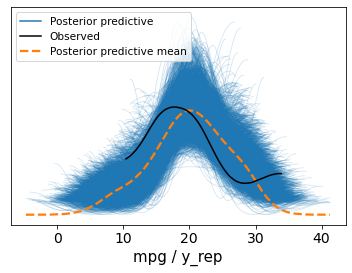

In [35]:
az.plot_ppc(idata, data_pairs={"mpg": "y_rep"})
plt.show()

In [36]:
draws = fit_basic.draws_pd()
draws.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_w,sigma,...,log_lik[23],log_lik[24],log_lik[25],log_lik[26],log_lik[27],log_lik[28],log_lik[29],log_lik[30],log_lik[31],log_lik[32]
0,-49.5666,1.000000,0.768778,2.0,3.0,0.0,50.4044,20.1331,-5.43704,2.90722,...,-2.81767,-2.68910,-2.34999,-1.98839,-1.98614,-2.04540,-3.23246,-2.47165,-2.59766,-2.05908
1,-49.8169,0.885138,0.768778,3.0,7.0,0.0,50.6577,19.8917,-5.27109,2.76848,...,-2.75657,-2.65161,-2.38409,-1.96475,-1.94930,-2.08895,-3.16644,-2.36118,-2.53709,-1.97862
2,-49.8149,0.852722,0.768778,3.0,7.0,0.0,50.9093,19.7310,-5.49004,3.12241,...,-2.62815,-2.52285,-2.49342,-2.07192,-2.06400,-2.14590,-2.95810,-2.37461,-2.45802,-2.08499
3,-50.3051,0.939101,0.768778,3.0,7.0,0.0,50.8203,20.1332,-5.98090,3.26784,...,-2.72033,-2.55553,-2.47576,-2.11488,-2.11861,-2.10332,-3.10064,-2.55540,-2.53108,-2.18819
4,-50.0389,1.000000,0.768778,2.0,3.0,0.0,50.4690,20.1008,-5.90941,3.03239,...,-2.73848,-2.55783,-2.45730,-2.03606,-2.04013,-2.03112,-3.16887,-2.53204,-2.52297,-2.11803


In [37]:
lp_basic = draws['lp__']
alpha_basic = draws['alpha']
beta_basic = draws['beta_w']

alpha_mean_basic = alpha_basic.mean()
beta_mean_basic = beta_basic.mean()

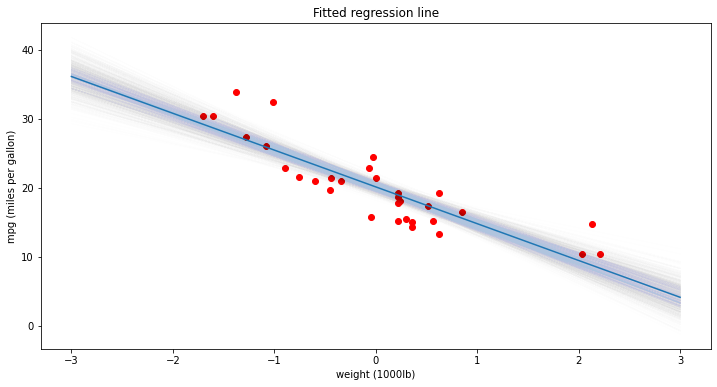

In [38]:
show_regression(alpha_basic, beta_basic, alpha_mean_basic, beta_mean_basic)

Now let's build a more complex model that we will use later in the project.

Here is the model that we want to estimate in Stan:

$$ mpg \thicksim Normal(\mu, \sigma) $$

$$ \mu = \alpha + \beta_{weight} \cdot weight_{center} + \beta_{cylinders} \cdot cylinders_{center} + 
\beta_{hp} + hp_{center}$$


### Posterior Model

Posterior Predictive Checks is designed to see how well our model can generate data that matches observed data. If a model is properly built, it should be able to generate new observations that very closely similar to given data.

In [39]:
with open('stan/ppc_model.stan') as file:
    print(file.read())

data {
  int N;
  vector[N] mpg;
  vector[N] weight_center;
  vector[N] cylinders_center;
  vector[N] hp_center;
}

parameters {
  real alpha;
  real beta_w;
  real beta_cyl;
  real beta_hp;
  real<lower = 0> sigma;
}

transformed parameters {
 vector[N] mu;
 mu = alpha + beta_w * weight_center + beta_cyl * cylinders_center + beta_hp * hp_center;
}

model {
  mpg ~ normal(mu, sigma);
}

generated quantities {
  real y_rep[N] = normal_rng(alpha + beta_w * weight_center + beta_cyl * 
    cylinders_center + beta_hp * hp_center, sigma);
  vector[N] log_lik;
 
  for (i in 1:N) {
    log_lik[i] = normal_lpdf(mpg[i] | mu[i], sigma);
  }
}



`normal_rng` is the stan function to generate observations from a normal distribution.
`y_rep` generates new data points from a normal distribution using the linear model.

In [40]:
N = data.shape[0]

model_data = {
    "mpg": data['mpg'],
    "weight_center": data.wt_center,
    "hp_center": data.hp_center,
    "cylinders_center": data.cyl_center,
    "N": N
}

In [41]:
model_ppc = CmdStanModel(stan_file='stan/ppc_model.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [42]:
fit_ppc = model_ppc.sample(data=model_data, fixed_param=False, seed=SEED)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [43]:
fit_ppc.summary().head(10)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-45.000,0.04200,1.700,-48.000,-45.000,-43.0000,1700.0,3400.0,1.0
alpha,20.000,0.00760,0.460,19.000,20.000,21.0000,3700.0,7700.0,1.0
beta_w,-3.200,0.01400,0.780,-4.500,-3.200,-1.9000,3200.0,6500.0,1.0
beta_cyl,-0.930,0.01200,0.600,-1.900,-0.930,0.0650,2300.0,4800.0,1.0
beta_hp,-0.018,0.00026,0.013,-0.039,-0.018,0.0031,2400.0,5000.0,1.0
sigma,2.600,0.00720,0.370,2.100,2.600,3.3000,2700.0,5600.0,1.0
mu[1],23.000,0.01400,0.740,22.000,23.000,24.0000,2893.0,5965.0,1.0
mu[2],22.000,0.01200,0.660,21.000,22.000,23.0000,2921.0,6022.0,1.0
mu[3],26.000,0.01300,0.770,25.000,26.000,27.0000,3832.0,7900.0,1.0


At this stage we can interpret the results:

- `alpha` If vehicle’s weight is held at its average value, the expected MPG is `20.00`.

- `beta_w` Comparing two cars who differ by 1000 pounds, the model predicts a difference of `3.20` miles per gallon.

- `beta_cyl` The number of cylinders has less influence on fuel consumption than the weight of the vehicle. Model predicts `0.95`.

- `beta_hp` Parameter has minimal impact on the outcome.

- `sigma` The model predicts miles per gallon to be `2.60`.

- `lp__` Logarithm of the posterior density. This parameter can be used in various ways for model evaluation and comparison. This estimate has a slightly lower value (in absolute value) than the basic model indicating that this model performs slightly better

In [44]:
y_pred = fit_ppc.stan_variable('y_rep')
y_pred.shape

(4000, 32)

We have a replicated `y_rep` value for every row of data. We can use these values to plot the replicated data against the observed data.

In [45]:
idata = az.from_cmdstanpy(
    posterior=fit_ppc,
    posterior_predictive=["y_rep"], 
    observed_data={"mpg": data['mpg']},
)

/Users/dominikwozniak/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


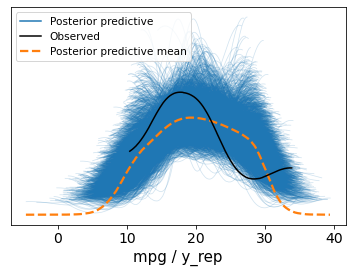

In [46]:
az.plot_ppc(idata, data_pairs={"mpg": "y_rep"})
plt.show()

The closer the replicated values - `y_rep` - get to the observed values (`y`) the more accurate the model. The model could be probably do a bit better, Maybe is likely due to the small size of data - which adds more uncertainty.

In [47]:
az.loo(idata)

Computed from 4000 by 32 log-likelihood matrix

         Estimate       SE
elpd_loo   -78.51     4.53
p_loo        4.91        -

In [48]:
az.waic(idata)

/Users/dominikwozniak/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 32 log-likelihood matrix

          Estimate       SE
elpd_waic   -78.29     4.45
p_waic        4.69        -

There has been a warning during the calculation. Please check the results.

In [49]:
draws = fit_ppc.draws_pd()
draws.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_w,beta_cyl,...,log_lik[23],log_lik[24],log_lik[25],log_lik[26],log_lik[27],log_lik[28],log_lik[29],log_lik[30],log_lik[31],log_lik[32]
0,-43.6161,0.954234,0.35966,3.0,15.0,0.0,46.3597,20.5913,-3.20763,-0.838611,...,-2.56997,-2.18320,-2.40108,-1.96843,-1.98783,-2.16615,-2.03520,-2.18517,-1.95295,-2.57649
1,-44.0603,0.928521,0.35966,3.0,7.0,0.0,44.7487,19.6743,-3.12530,-0.796154,...,-2.23162,-1.73000,-3.12674,-1.75172,-1.74542,-2.43613,-1.80023,-1.77643,-2.85618,-2.33947
2,-46.1044,0.868326,0.35966,3.0,7.0,0.0,48.1273,20.3081,-4.35995,-0.777023,...,-2.45079,-2.25680,-2.63063,-2.18050,-2.19487,-2.12839,-2.29219,-2.37360,-2.11532,-2.51012
3,-43.8904,0.942956,0.35966,4.0,15.0,0.0,48.2658,19.6336,-2.79613,-1.153530,...,-1.99533,-1.72566,-3.37435,-1.71900,-1.73004,-2.47707,-1.76525,-1.77565,-2.39799,-2.51863
4,-44.1139,1.000000,0.35966,4.0,15.0,0.0,44.8241,20.5359,-3.72561,-0.318740,...,-2.90837,-2.19328,-2.27262,-1.96951,-1.96427,-2.20221,-2.08951,-2.17053,-1.99299,-2.30472


In [50]:
lp = draws['lp__']
alpha = draws['alpha']
beta = draws['beta_w']
beta_w = draws['beta_w']
beta_cyl = draws['beta_cyl']
beta_hp = draws['beta_hp']
sigma = draws['sigma']

alpha_mean = alpha.mean()
beta_mean = beta.mean()

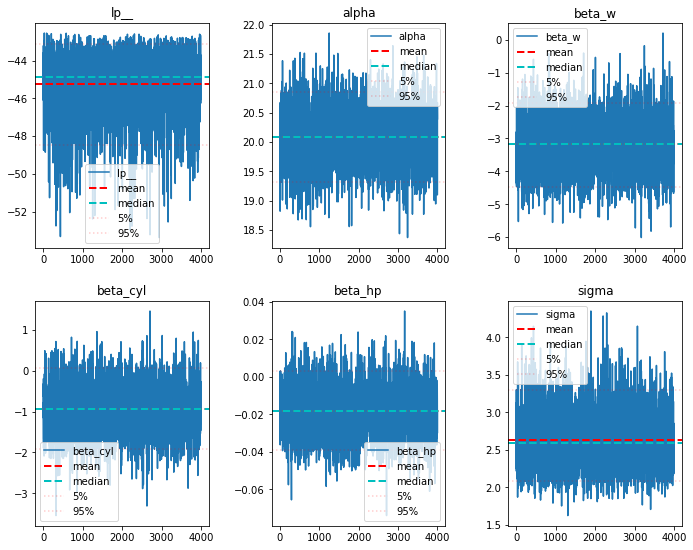

In [51]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

subplot_trace(axs, lp, 'lp__', 0, 0)
subplot_trace(axs, alpha, 'alpha', 0, 1)
subplot_trace(axs, beta_w, 'beta_w', 0, 2)
subplot_trace(axs, beta_cyl, 'beta_cyl', 1, 0)
subplot_trace(axs, beta_hp, 'beta_hp', 1, 1)
subplot_trace(axs, sigma, 'sigma', 1, 2)

fig.tight_layout(pad=2.0)
plt.show()

- we want to check that our chains have converged and are producing reliable point estimates. We can see that the movement through parameter space resembles a random walk, which is indicative that the underlying Markov chain has reached convergence as we would hope.
- The fuzzy caterpillar appearance indicates that the chains are mixing well and have converged to a common distribution.

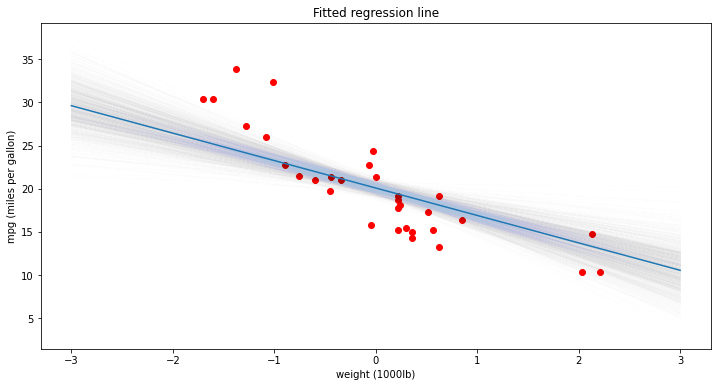

In [52]:
show_regression(alpha, beta, alpha_mean, beta_mean)

### Improve Priors Model

To improve model we can use **more imfornamtive priors**. Priors allows us to use background knowledge to use in the model. We will obtain more realistic estimates as a result.

We didn't use priors in the previous model. It used flat priors by default - it place all possible coefficient values an equal probably. The scenario without priors isn't very realistic.

<AxesSubplot:>

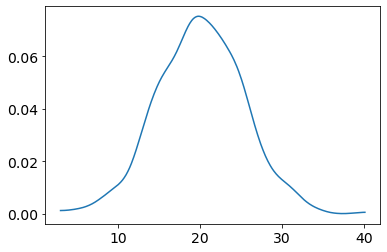

In [53]:
alpha_ = np.random.normal(20, 5, 1000)
az.plot_dist(alpha_)

<AxesSubplot:>

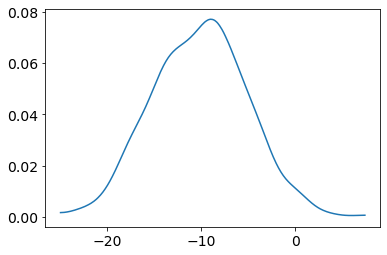

In [54]:
beta_weight_ = np.random.normal(-10, 5, 1000)
az.plot_dist(beta_weight_)

<AxesSubplot:>

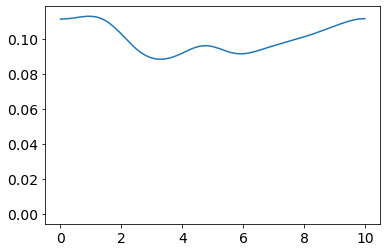

In [55]:
sigma_ = np.random.uniform(0, 10, 1000)
az.plot_dist(sigma_)

<AxesSubplot:>

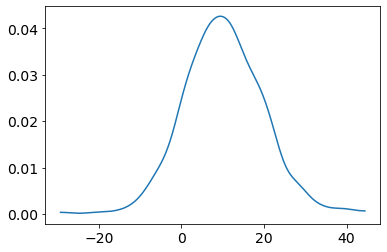

In [56]:
prior_mpg = np.random.normal(alpha_ + beta_weight_, sigma_, 1000)
az.plot_dist(prior_mpg)

Not a perfect match, but sufficient for testing. The expected effect of weight on MPG is negative and and majority of the mass is concentrated between -15 and -5. Similarly, the expected MPG given these priors is between -10 and 20.

In [57]:
with open('stan/prior_improve_model.stan') as file:
    print(file.read())

data {
  int N;
  vector[N] mpg;
  vector[N] weight_center;
  vector[N] cylinders_center;
  vector[N] hp_center;
}

parameters {
  real alpha;
  real beta_w;
  real beta_cyl;
  real beta_hp;
  real<lower = 0> sigma;
}

transformed parameters {
 vector[N] mu;
 mu = alpha + beta_w * weight_center + beta_cyl * cylinders_center + beta_hp * hp_center;
}

model {
  alpha ~ normal(20, 5);
  beta_w ~ normal(-10, 5);
  beta_cyl ~ normal(0, 5);
  beta_hp ~ normal(0, 5);
  sigma ~ uniform(0, 10);
  
  mpg ~ normal(mu, sigma);
}

generated quantities {
  real y_rep[N] = normal_rng(alpha + beta_w * weight_center + beta_cyl * 
  cylinders_center + beta_hp * hp_center, sigma);
  
  vector[N] log_lik;
  for (i in 1:N) {
    log_lik[i] = normal_lpdf(mpg[i] | mu[i], sigma);
  }
}



In [58]:
model_prior = CmdStanModel(stan_file='stan/prior_improve_model.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [77]:
fit_prior = model_prior.sample(data=model_data, seed=SEED)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [78]:
fit_prior.summary().head(10)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-46.000,0.04900,1.700,-49.000,-46.000,-44.0000,1200.0,1700.0,1.0
alpha,20.000,0.00800,0.470,19.000,20.000,21.0000,3400.0,4700.0,1.0
beta_w,-3.400,0.01600,0.780,-4.600,-3.400,-2.1000,2300.0,3300.0,1.0
beta_cyl,-0.850,0.01300,0.580,-1.800,-0.870,0.1200,2000.0,2800.0,1.0
beta_hp,-0.018,0.00024,0.012,-0.039,-0.018,0.0025,2700.0,3800.0,1.0
sigma,2.600,0.01200,0.370,2.100,2.600,3.3000,980.0,1400.0,1.0
mu[1],23.000,0.01400,0.720,22.000,23.000,24.0000,2683.0,3737.0,1.0
mu[2],22.000,0.01200,0.630,21.000,22.000,23.0000,2940.0,4095.0,1.0
mu[3],26.000,0.01300,0.770,25.000,26.000,27.0000,3355.0,4673.0,1.0


In [79]:
draws_prior = fit_prior.draws_pd()
draws_prior.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_w,beta_cyl,...,log_lik[23],log_lik[24],log_lik[25],log_lik[26],log_lik[27],log_lik[28],log_lik[29],log_lik[30],log_lik[31],log_lik[32]
0,-44.1392,0.997218,0.312177,3.0,7.0,0.0,45.6392,19.8417,-2.71145,-1.06576,...,-2.14900,-1.80411,-2.98863,-1.76635,-1.77535,-2.50560,-1.78140,-1.83855,-2.27816,-2.49929
1,-45.9954,0.920928,0.312177,3.0,7.0,0.0,46.7988,19.3780,-2.45475,-1.01171,...,-2.11410,-1.91336,-3.01409,-1.91675,-1.91450,-2.82997,-2.06803,-1.91421,-2.86362,-2.28974
2,-47.2779,0.966227,0.312177,3.0,15.0,0.0,48.0751,19.3267,-1.79544,-1.27061,...,-2.06142,-1.95617,-2.93389,-2.02598,-1.97823,-3.25309,-2.04029,-1.94183,-2.41055,-2.28623
3,-46.6166,0.995085,0.312177,3.0,7.0,0.0,48.4492,19.4462,-1.96985,-1.41609,...,-2.06603,-1.99099,-2.99690,-2.00461,-1.98525,-2.85309,-2.06605,-1.98874,-2.38486,-2.43719
4,-48.3419,0.729130,0.312177,2.0,3.0,0.0,50.1421,19.4120,-2.18238,-1.60169,...,-2.03815,-2.04791,-3.33576,-2.02940,-2.04283,-2.46453,-2.33658,-2.00936,-3.12244,-2.70416


- `lp__` - logarithm of the posterior density. This parameter can be used in various ways for model evaluation and comparison.
- After estimating the model with more informative priors, the `lp__` is now a little bit lower.

In [80]:
idata = az.from_cmdstanpy(
    posterior=fit_prior,
    posterior_predictive=["y_rep"], 
    observed_data={"mpg": data['mpg']},
)

<AxesSubplot:xlabel='mpg / y_rep'>

/Users/dominikwozniak/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


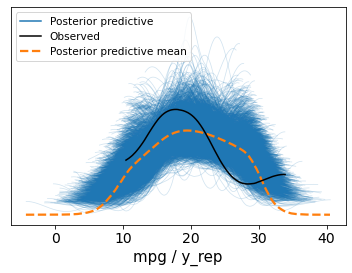

In [81]:
az.plot_ppc(idata, data_pairs={"mpg": "y_rep"})

In [82]:
az.loo(idata)

Computed from 4000 by 32 log-likelihood matrix

         Estimate       SE
elpd_loo   -78.38     4.49
p_loo        4.79        -

In [83]:
az.waic(idata)

/Users/dominikwozniak/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 32 log-likelihood matrix

          Estimate       SE
elpd_waic   -78.19     4.42
p_waic        4.60        -

There has been a warning during the calculation. Please check the results.

In [84]:
lp_prior = draws_prior['lp__']
alpha_prior = draws_prior['alpha']
beta_prior = draws_prior['beta_w']
beta_w_prior = draws_prior['beta_w']
beta_cyl_prior = draws_prior['beta_cyl']
beta_hp_prior = draws_prior['beta_hp']
sigma_prior = draws_prior['sigma']

alpha_mean_prior = alpha_prior.mean()
beta_mean_prior = beta_prior.mean()

- we can compare the prior distribution to the posterior distribution to see how “powerful” our priors are.
- we can see that even with more “informative priors” they are still very weak compared to other the data.

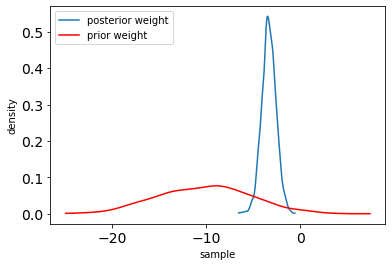

In [85]:
az.plot_dist(beta_prior, label='posterior weight')
az.plot_dist(beta_weight_, color='r', label='prior weight')
plt.xlabel('sample')
plt.ylabel('density')
plt.legend()
plt.show()

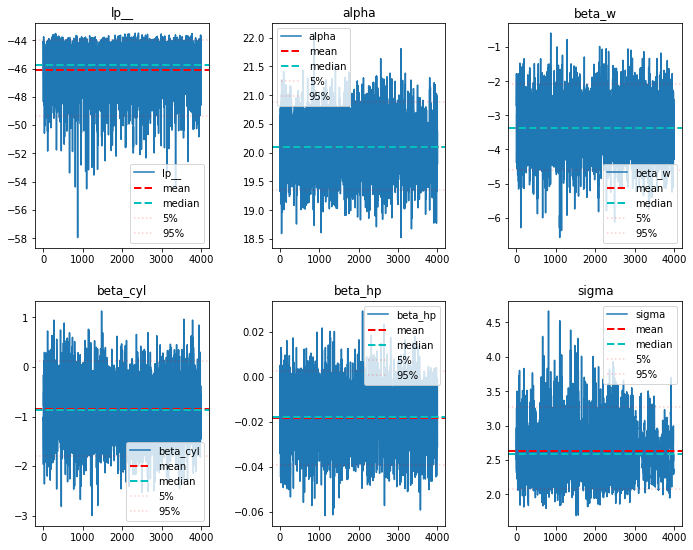

In [86]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

subplot_trace(axs, lp_prior, 'lp__', 0, 0)
subplot_trace(axs, alpha_prior, 'alpha', 0, 1)
subplot_trace(axs, beta_w_prior, 'beta_w', 0, 2)
subplot_trace(axs, beta_cyl_prior, 'beta_cyl', 1, 0)
subplot_trace(axs, beta_hp_prior, 'beta_hp', 1, 1)
subplot_trace(axs, sigma_prior, 'sigma', 1, 2)

fig.tight_layout(pad=2.0)
plt.show()

- Markov chain has reached convergence for this case as well

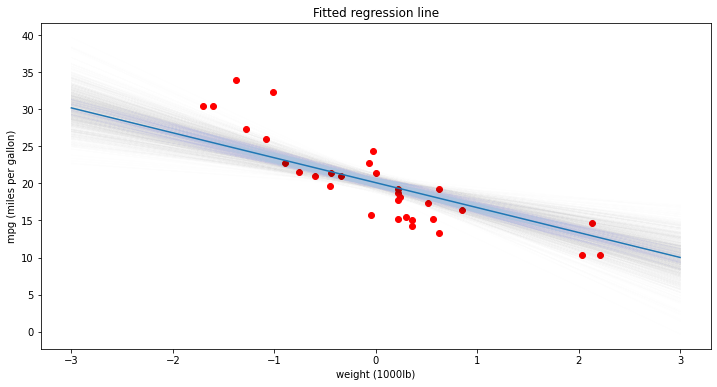

In [87]:
show_regression(alpha_prior, beta_prior, alpha_mean_prior, beta_mean_prior)

## Compare models

In [88]:
fit_1 = az.from_cmdstanpy(
    posterior=fit_ppc,
    log_likelihood='log_lik',
    posterior_predictive=["y_rep"], 
    observed_data={"mpg": data['mpg']},
)

fit_2 = az.from_cmdstanpy(
    posterior=fit_prior,
    log_likelihood='log_lik',
    posterior_predictive=["y_rep"], 
    observed_data={"mpg": data['mpg']},
)

fit_3 = az.from_cmdstanpy(
    posterior=fit_basic,
    log_likelihood='log_lik',
    posterior_predictive=["y_rep"], 
    observed_data={"mpg": data['mpg']},
)

In [89]:
model_compare_loo = az.compare(dataset_dict ={
    'Posterior Predictive Checks Model':fit_1,
    'Improve Priors Model':fit_2,
    'Basic model': fit_3
})

model_compare_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Improve Priors Model,0,-78.380233,4.789082,0.000000,1.0,4.491275,0.000000,False,log
Posterior Predictive Checks Model,1,-78.506752,4.905992,0.126519,0.0,4.526720,0.227648,False,log
Basic model,2,-83.573426,3.288909,5.193193,0.0,4.172154,2.272038,False,log


In [90]:
model_compare_waic = az.compare(dataset_dict ={
    'Posterior Predictive Checks Model':fit_1,
    'Improve Priors Model':fit_2,
    'Basic model': fit_3
    },
    ic='waic'
)

model_compare_waic

/Users/dominikwozniak/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/dominikwozniak/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/dominikwozniak/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Improve Priors Model,0,-78.192362,4.601210,0.000000,1.000000e+00,4.424312,0.000000,True,log
Posterior Predictive Checks Model,1,-78.286483,4.685724,0.094122,1.471046e-15,4.447839,0.208471,True,log
Basic model,2,-83.461892,3.177375,5.269531,3.330669e-16,4.121332,2.266495,True,log


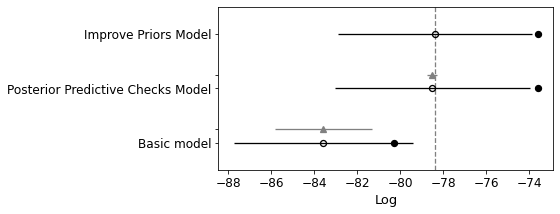

In [91]:
az.plot_compare(model_compare_loo)
plt.show()

Both models got very simillar results. Improve Prios Model provides a little better predictions. Improve Prios Model provides have minimal better out-of-sample performance (open dots). Furthermore this model have better in-sample performance (solid dots).

We can also see from the graphs that both built models behave better than the basic model and give better results.

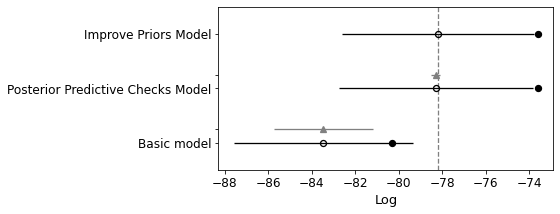

In [92]:
az.plot_compare(model_compare_waic)
plt.show()

Compare two models in plots shown below looks very similar lines. It confirms obtained results - `loo` and `waic` have very similar values.

Both models can be used with linear problems with high efficiency.

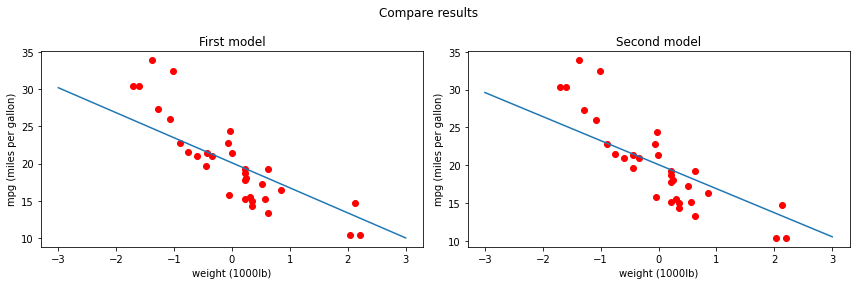

In [93]:
x_plot = np.linspace(-3, 3, 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Compare results')

ax1.set_title('First model')
ax1.plot(x_plot, alpha_mean_prior + beta_mean_prior * x_plot)
ax1.scatter(data['wt_center'], data['mpg'], color='r')
ax1.set(xlabel='weight (1000lb)', ylabel='mpg (miles per gallon)')

ax2.set_title('Second model')
ax2.plot(x_plot, alpha_mean + beta_mean * x_plot)
ax2.scatter(data['wt_center'], data['mpg'], color='r')
ax2.set(xlabel='weight (1000lb)', ylabel='mpg (miles per gallon)')

plt.gcf().tight_layout()

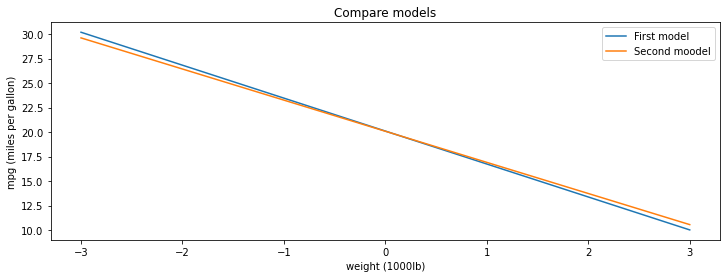

In [94]:
plt.figure(figsize=(12, 4))
plt.title('Compare models')
plt.plot(x_plot, alpha_mean_prior + beta_mean_prior * x_plot, label='First model')
plt.plot(x_plot, alpha_mean + beta_mean * x_plot, label='Second moodel')
plt.xlabel('weight (1000lb)')
plt.ylabel('mpg (miles per gallon)')
plt.legend()
plt.show()

### Notes

> `loo` - Leave-one-out cross-validation is a special case of cross-validation where the number of folds equals the number of instances in the data set.

Leave-one-out cross-validation uses the following approach to evaluate a model:

1. Split a dataset into a training set and a testing set, using all but one observation as part of the training set Note that we only leave one observation “out” from the training set. This is where the method gets the name “leave-one-out” cross-validation.

2. Build the model using only data from the training set

3. Use the model to predict the response value of the one observation left out of the model and calculate the MSE.

4. Repeat the process `n` times.

5. Lastly, we repeat this process `n` times (where n is the total number of observations in the dataset), leaving out a different observation from the training set each time.